# 混合モデルと近似推論
https://www.amazon.co.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%B9%E3%82%BF%E3%83%BC%E3%83%88%E3%82%A2%E3%83%83%E3%83%97%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E3%83%99%E3%82%A4%E3%82%BA%E6%8E%A8%E8%AB%96%E3%81%AB%E3%82%88%E3%82%8B%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E5%85%A5%E9%96%80-KS%E6%83%85%E5%A0%B1%E7%A7%91%E5%AD%A6%E5%B0%82%E9%96%80%E6%9B%B8-%E9%A0%88%E5%B1%B1-%E6%95%A6%E5%BF%97/dp/4061538322/ref=pd_lpo_sccl_1/357-1883824-8378404?pd_rd_w=Ppwn7&content-id=amzn1.sym.d769922e-188a-40cc-a180-3315f856e8d6&pf_rd_p=d769922e-188a-40cc-a180-3315f856e8d6&pf_rd_r=FZTFK68376X7D0ZJN3CH&pd_rd_wg=26Ise&pd_rd_r=8eec0c7c-9e68-456c-977b-39077482792c&pd_rd_i=4061538322&psc=1

## 図1.4　ガウス混合モデルによるクラスタリング
### データの生成過程
データを表現するためのモデルを構築するためには，「観測されたデータ点1つ１つがどの様な過程で生成されるのか」を具体的に想定する必要があります．

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [11]:
a = np.array([1, 2, 3])
np.random.choice(a, size=2, replace = False, p=[0.1, 0.8, 0.1])

array([2, 1])

In [12]:
np.random.choice(a, size=100, replace = True, p=[0.4, 0.3, 0.3])

array([1, 3, 1, 2, 1, 3, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 1, 2, 1,
       1, 3, 3, 1, 3, 1, 2, 3, 1, 2, 3, 1, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3,
       2, 1, 1, 3, 1, 3, 3, 2, 2, 1, 1, 3, 2, 3, 3, 3, 3, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 3, 3, 3, 2, 1, 2, 3, 1, 3, 1, 3, 3, 1, 2, 2, 1, 1, 3,
       2, 3, 3, 3, 1, 3, 1, 2, 3, 1, 2, 1])

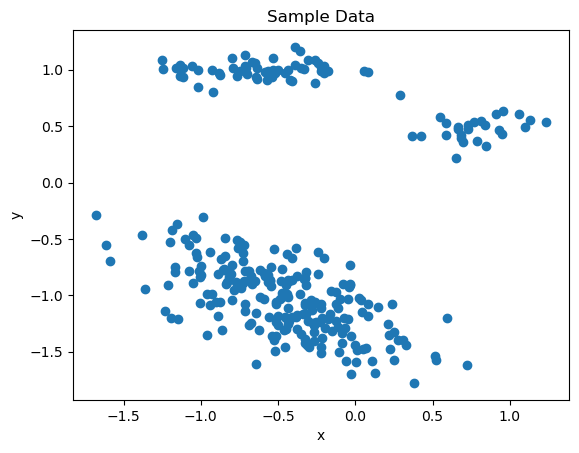

In [13]:
np.random.seed(0)

# パラメータの設定
num_samples = 300
# クラスタの数
num_clusters = 3
# 混合比率
weights = [0.7, 0.1, 0.2]
# それぞれのクラスタに対するパラメータの設定
means = [[-0.5, -1.0], [0.8, 0.5], [-0.5, 1.0]]
covariances = [[[0.20, -0.1], [-0.1, 0.10]],
               [[0.05, 0], [0, 0.01]],
               [[0.1, 0], [0, 0.01]]]

# クラスタ番号をサンプリング
cluster_indices = np.random.choice(num_clusters, size=num_samples, p=weights)

# 各クラスタからデータを生成
samples = []
for idx in cluster_indices:
    # クラスタに対するガウス乱数を生成
    sample = np.random.multivariate_normal(means[idx], covariances[idx])
    samples.append(sample)

samples = np.array(samples)

# データの可視化資料
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sample Data')
plt.show()

## 図4.1　単一のガウス分布による表現
### 単一のガウス分布と仮定し推定

In [14]:
# パラメータの推定
estimated_mean = np.mean(samples, axis=0)
estimated_cov = np.cov(samples.T)
print('estimated mean: ', estimated_mean)
print('estimated covariance: ', estimated_cov)

estimated mean:  [-0.38621512 -0.50911379]
estimated covariance:  [[0.28890824 0.01249126]
 [0.01249126 0.80158651]]


/tmp/ipykernel_878206/2767591818.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x, y, estimated_pdf, levels=5, colors='r', alpha=0.5, label='Estimated Gaussian')


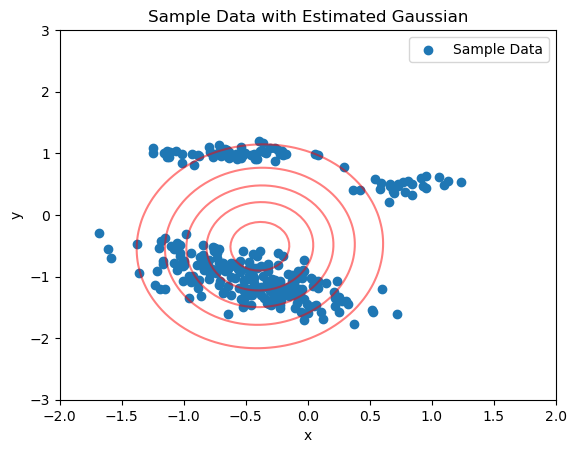

In [15]:
# 推定したガウス分布のメッシュグリッド
x, y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-3, 3, 100))
pos = np.dstack((x, y))
estimated_pdf = multivariate_normal.pdf(pos, estimated_mean, estimated_cov)

# データと推定したガウス分布の可視化
plt.scatter(samples[:, 0], samples[:, 1], label='Sample Data')
plt.contour(x, y, estimated_pdf, levels=5, colors='r', alpha=0.5, label='Estimated Gaussian')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sample Data with Estimated Gaussian')
plt.legend()
plt.show()

## 図4.4　2次元ガウス分布に対するギブスサンプリング

条件付き正規分布の公式
$$
E[x|y] = \mu_x + \Sigma_{xy}\Sigma_{yy}^{-1}(y-\mu_y) \\
Var[x|y] = \Sigma_{xx} - \Sigma_{xy}\Sigma_{yy}^{-1}\Sigma_{yx}
$$

ギブスサンプリングは他の変数が固定されたという条件の元で，一つの変数に対してサンプリングを施す手法であるから，アルゴリズムは以下のようになる．

1. $y_0$を初期値として保存
2. $y_0$を固定した上で，$x_1$をサンプリング
3. $x_1$を固定した上で，$y_1$をサンプリング
4. 繰り返し

In [16]:
def gibbs_sampling_2d_gaussian(num_samples, mu, sigma):
    # 初期化
    x_samples = np.zeros(num_samples)
    y_samples = np.zeros(num_samples)

    for i in range(1, num_samples):
        # xのサンプリング
        x_mean = mu[0] + sigma[0, 1] * (y_samples[i-1] - mu[1]) / sigma[1, 1]
        x_variance = sigma[0, 0] - sigma[0, 1] * sigma[1, 0] / sigma[1, 1]
        x_samples[i] = np.random.normal(x_mean, np.sqrt(x_variance))

        # yのサンプリング
        y_mean = mu[1] + sigma[1, 0] * (x_samples[i] - mu[0]) / sigma[0, 0]
        y_variance = sigma[1, 1] - sigma[1, 0] * sigma[0, 1] / sigma[0, 0]
        y_samples[i] = np.random.normal(y_mean, np.sqrt(y_variance))

    return x_samples, y_samples

/tmp/ipykernel_878206/2393242367.py:22: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=1, colors='blue', alpha=0.5, label='Estimated Gaussian Distribution')


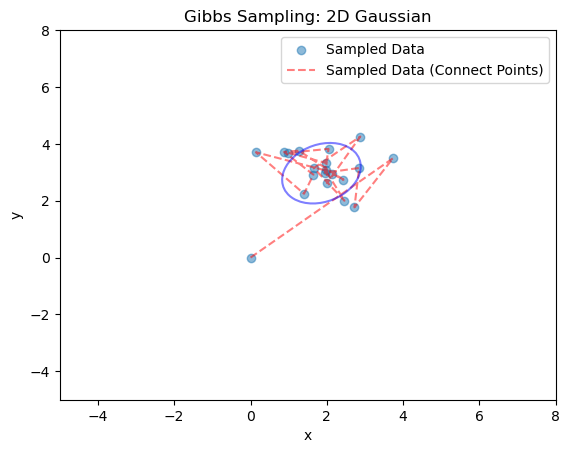

In [17]:
# パラメータの設定
num_samples = 20
mu = np.array([2, 3])  # 平均
sigma = np.array([[1, -1.0], [-1.0, 2]])  # 共分散行列

# ギブスサンプリングの実行
x_samples, y_samples = gibbs_sampling_2d_gaussian(num_samples, mu, sigma)

# 推定したガウス分布のパラメータを計算
estimated_mu = np.mean([x_samples, y_samples], axis=1)
estimated_cov = np.cov(np.vstack((x_samples, y_samples)))

# 分布のグリッドを作成
x = np.linspace(-5, 8, 100)
y = np.linspace(-5, 8, 100)
X, Y = np.meshgrid(x, y)
Z = multivariate_normal.pdf(np.dstack((X, Y)), mean=estimated_mu, cov=estimated_cov)

# 結果の表示
plt.scatter(x_samples, y_samples, alpha=0.5, label='Sampled Data')
plt.plot(x_samples, y_samples, '--', alpha=0.5, color='red', label='Sampled Data (Connect Points)')
plt.contour(X, Y, Z, levels=1, colors='blue', alpha=0.5, label='Estimated Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gibbs Sampling: 2D Gaussian')
plt.legend()
plt.show()

## 図4.5　2次元ガウス分布に対する平均場近似
https://masamunetogetoge.com/mean-field

平均場近似における近似分布は以下のようになります．
$$
\ln{q(z_i)} = <\ln{p(z_1 , ... , z_M|D)}>_{q(Z_i)} + const
$$

2次元正規分布の場合には，平均場近似における近似分布は以下のようになります．
$$
p(\vec{z}) = \mathcal{N}(\vec{z}|\vec{\mu},\Sigma)
$$
としたときに
$$
q(z_i) = \mathcal{N}(z_i|\mu_i,\Sigma^{-1}_{ii})
$$

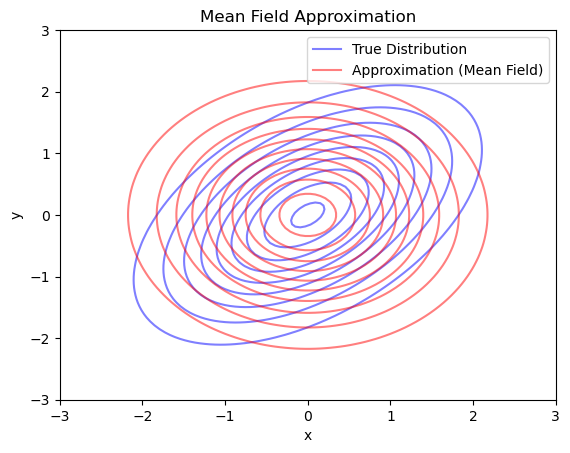

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def mean_field_approximation(mu, sigma):
    # 平均場近似に基づいて近似分布を計算する関数

    # 近似分布のパラメータを計算
    mu_i = mu.copy()
    sigma_ii = np.diag(sigma)

    return mu_i, sigma_ii

# 正規分布のパラメータ
mu = np.array([0, 0])  # 平均ベクトル
sigma = np.array([[1, 0.5], [0.5, 1]])  # 共分散行列

# 平均場近似による近似分布の計算
mu_i, sigma_ii = mean_field_approximation(mu, sigma)

# グリッド上の点に対して確率密度を計算
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# 真の分布の確率密度を計算
Z = multivariate_normal.pdf(np.dstack((X, Y)), mean=mu, cov=sigma)

# 近似分布の確率密度を計算
Q = multivariate_normal.pdf(np.dstack((X, Y)), mean=mu_i, cov=np.diag(sigma_ii))

# 確率密度のプロット
fig, ax = plt.subplots()
ax.contour(X, Y, Z, colors='blue', alpha=0.5, levels=10)
ax.contour(X, Y, Q, colors='red', alpha=0.5, levels=10)

# 凡例の作成
true_dist = plt.Line2D([], [], color='blue', alpha=0.5, label='True Distribution')
approximation = plt.Line2D([], [], color='red', alpha=0.5, label='Approximation (Mean Field)')
ax.legend(handles=[true_dist, approximation])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Field Approximation')
plt.show()

PyMC3を使った実装

Finished [100%]: Average Loss = 2,830.9
/tmp/ipykernel_878206/1386055080.py:52: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_true, colors='blue', label='True distribution')
/tmp/ipykernel_878206/1386055080.py:53: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_estimated, colors='green', label='Estimated distribution')


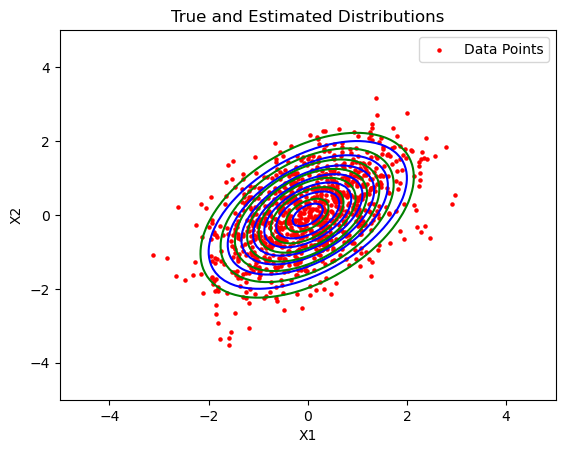

In [21]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

# まず、真の2次元ガウス分布のパラメータを設定します
mu_true = [0, 0]
cov_true = [[1, 0.5], [0.5, 1]]

# 真の分布からサンプルを生成します
num_samples = 1000
data = np.random.multivariate_normal(mu_true, cov_true, num_samples)

# PyMC3で平均場近似を使用して2次元ガウス分布を学習します
with pm.Model() as model:
    # 事前分布
    mu = pm.Normal("mu", mu=0, sd=10, shape=2)
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                  eta=2., sd_dist=pm.Exponential.dist(1.0))
    
    # 共分散行列
    L = pm.expand_packed_triangular(2, packed_L)
    sigma = pm.Deterministic('sigma', L.dot(L.T))
    
    # 事後分布
    obs = pm.MvNormal("obs", mu=mu, chol=L, observed=data)
    
    # 平均場近似
    mean_field = pm.fit()

# サンプルを抽出
samples = mean_field.sample(1000)

# グリッドを作成
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# 真の分布のPDFを計算
from scipy.stats import multivariate_normal
rv_true = multivariate_normal(mu_true, cov_true)
Z_true = rv_true.pdf(pos)

# 推定分布のPDFを計算
mu_estimated = np.mean(samples['mu'], axis=0)
sigma_estimated = np.mean(samples['sigma'], axis=0)
rv_estimated = multivariate_normal(mu_estimated, sigma_estimated)
Z_estimated = rv_estimated.pdf(pos)

# 等高線プロット
plt.contour(X, Y, Z_true, colors='blue', label='True distribution')
plt.contour(X, Y, Z_estimated, colors='green', label='Estimated distribution')

# データ点をプロット
plt.scatter(data[:, 0], data[:, 1], c='red', s=5, label="Data Points")

# 軸ラベルと凡例を表示
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('True and Estimated Distributions')
plt.show()